<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/22_3_%D0%AF%D0%BF%D0%BE%D0%BD%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv

--2024-10-18 11:59:27--  https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136735 (134K) [text/csv]
Saving to: ‘japan_cars_dataset.csv’

japan_cars_dataset. 100%[===================>] 133.53K   309KB/s    in 0.4s    

2024-10-18 11:59:29 (309 KB/s) - ‘japan_cars_dataset.csv’ saved [136735/136735]



In [2]:
import numpy as np
import pandas as pd
from keras import utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import json
import random

%matplotlib inline

In [3]:
cars = pd.read_csv('japan_cars_dataset.csv', sep=',')
cars = cars.dropna()

In [4]:
print('Форма данных: ', cars.shape)

Форма данных:  (2318, 11)


In [5]:
cars.head(3)

,Unnamed: 0,price,mark,model,year,mileage,engine_capacity,transmission,drive,hand_drive,fuel
0,0,80,nissan,march,2003,80000,1240,at,2wd,rhd,gasoline
1,1,110,nissan,march,2010,53000,1200,at,2wd,rhd,gasoline
2,2,165,nissan,lafesta,2005,47690,2000,at,2wd,rhd,gasoline


In [6]:
cars.drop(['Unnamed: 0', 'mileage'], inplace=True, axis=1)

In [7]:
cars.tail(3)

,price,mark,model,year,engine_capacity,transmission,drive,hand_drive,fuel
2315,1400,subaru,r2,2005,660,cvt,2wd,rhd,gasoline
2316,1400,honda,z,2000,660,at,4wd,rhd,gasoline
2317,1400,toyota,estima t,2005,3000,at,2wd,rhd,gasoline


In [8]:
n = random.randint(0, len(cars))
for i in range(len(cars.values[n])):
    print('{:>2} {:>30}  {}'.format(i, cars.columns[i], cars.values[n][i]))

 0                          price  500
 1                           mark  nissan
 2                          model  cube
 3                           year  2011
 4                engine_capacity  1500
 5                   transmission  at
 6                          drive  2wd
 7                     hand_drive  rhd
 8                           fuel  gasoline


In [9]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   price            2318 non-null   int64 
 1   mark             2318 non-null   object
 2   model            2318 non-null   object
 3   year             2318 non-null   int64 
 4   engine_capacity  2318 non-null   int64 
 5   transmission     2318 non-null   object
 6   drive            2318 non-null   object
 7   hand_drive       2318 non-null   object
 8   fuel             2318 non-null   object
dtypes: int64(3), object(6)
memory usage: 163.1+ KB


In [10]:
cars['price'].value_counts()

,count
price,
850,71
790,58
1306,57
1120,56
1220,45
...,...
1121,1
1122,1
1123,1


In [11]:
cars['fuel'].value_counts()

,count
fuel,
gasoline,2290
diesel,18
lpg,7
hybrid,2
cng,1


In [12]:
cars['hand_drive'].value_counts()

,count
hand_drive,
rhd,2301
lhd,16
center,1


In [13]:
cars['drive'].value_counts()

,count
drive,
2wd,2121
4wd,192
awd,5


In [14]:
cars['transmission'].value_counts()

,count
transmission,
at,2171
mt,117
cvt,30


In [15]:
cars['model'].value_counts()

,count
model,
fit,270
vitz,179
passo,127
ist,93
ractis,85
...,...
sx4 sedan,1
207,1
corolla ii,1


In [16]:
cars['mark'].value_counts()

,count
mark,
toyota,1047
honda,382
nissan,320
mazda,148
suzuki,126
mitsubishi,65
daihatsu,56
subaru,54
volkswagen,52


In [17]:
fuel_class =  {'gasoline'  : 0,
               'diesel'    : 1,
               'lpg'       : 2,
               'hybrid'    : 3,
               'cng'       : 4}

hand_class =  {'rhd'        : 0,
               'lhd'        : 1,
               'center'     : 2}


drive_class =  {'2wd'       : 0,
                '4wd'       : 1,
                'awd'       : 2}

trans_class =  {'at'        : 0,
                'mt'        : 1,
                'cvt'       : 2}

model_class =  {'fit'        : 0,
                'vitz'       : 1,
                'passo'      : 2,
                'ist'        : 3,
                'ractis'     : 4,
                'other'      : 5}

mark_class =  {'toyota'      : 0,
                'honda'      : 1,
                'nissan'     : 2,
                'mazda'      : 3,
                'suzuki'     : 4,
                'mitsubishi' : 5,
                'daihatsu'   : 6,
                'subaru'     : 7,
                'other'      : 8}


In [18]:
def str2multiOHE(param, class_dict):

    # Определение размерности выходного вектора, как число уникальных классов
    num_classes = len(set(class_dict.values()))

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Если не смогли распарсить, то поле не заполнено
    # Устанавливаем значение по умолчанию (последний элемент в словаре)
    if not param in class_dict.keys():
        param = list(class_dict.keys())[-1]

    # Поиск значения в словаре и, если нашли, то проставляем 1 в найденной позиции
    for value, cls in class_dict.items():
        if value in param:
            result[cls] = 1.

    return result

In [19]:
n = random.randint(0, len(cars))
print(n)
print('Тип топлива: ', cars.fuel[n])
print('Тип топлива в формате OHE: ', str2multiOHE(cars.fuel[n], fuel_class))
print()
print('Положение руля: ', cars.hand_drive[n])
print('Положение руля в формате OHE: ', str2multiOHE(cars.hand_drive[n], hand_class))
print()
print('Привод: ', cars.drive[n])
print('Привод в формате OHE: ', str2multiOHE(cars.drive[n], drive_class))
print()
print('Трансмиссия: ', cars.transmission[n])
print('Трансмиссия в формате OHE: ', str2multiOHE(cars.transmission[n], trans_class))
print()
print('Модель: ', cars.model[n])
print('Модель в формате OHE: ', str2multiOHE(cars.model[n], model_class))
print()
print('Модель: ', cars.mark[n])
print('Модель в формате OHE: ', str2multiOHE(cars.mark[n], mark_class))

1120
Тип топлива:  gasoline
Тип топлива в формате OHE:  [1. 0. 0. 0. 0.]

Положение руля:  rhd
Положение руля в формате OHE:  [1. 0. 0.]

Привод:  2wd
Привод в формате OHE:  [1. 0. 0.]

Трансмиссия:  at
Трансмиссия в формате OHE:  [1. 0. 0.]

Модель:  fit
Модель в формате OHE:  [1. 0. 0. 0. 0. 0.]

Модель:  honda
Модель в формате OHE:  [0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
cars['engine_capacity'].value_counts()

,count
engine_capacity,
1300,468
1500,433
2000,197
1000,168
660,159
...,...
1986,1
798,1
1587,1


In [21]:
cars['year'].value_counts()

,count
year,
2005,365
2007,318
2003,248
2006,199
2009,199
2004,194
2011,173
2010,153
2008,91


In [22]:
cars.max()

,0
price,1400
mark,volvo
model,zest
year,2015
engine_capacity,12340
transmission,mt
drive,awd
hand_drive,rhd
fuel,lpg


In [23]:
cars.min()

,0
price,80
mark,audi
model,1 series
year,1979
engine_capacity,9
transmission,at
drive,2wd
hand_drive,center
fuel,cng


In [24]:
# Список порогов возраста
year_class = [1994, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015]

# Список порогов объема
engine_class = [500, 1000, 1500, 2000, 2500, 3000]

In [25]:
def range2OHE(param, class_list):

   # Определение размерности выходного вектора, как число уникальных классов
    num_classes = len(class_list)+1

    # Поиск интервала для входного значения
    for i in range(num_classes - 1):
        if float(param) < class_list[i]:
            cls = i                       # Интервал найден, выбор класса
            break
    else:
        cls = num_classes - 1             # Интервал не найден, выбор последнего класса

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [26]:
n = random.randint(0, len(cars))
print(n)
print('Год выпуска: ', cars.year[n])
print('Год выпуска в формате OHE: ',range2OHE(cars.year[n], year_class))

print('Объем двигателя: ', cars.engine_capacity[n])
print('Объем двигателя в формате OHE: ', range2OHE(cars.engine_capacity[n], engine_class))

530
Год выпуска:  2006
Год выпуска в формате OHE:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Объем двигателя:  1320
Объем двигателя в формате OHE:  [0. 0. 1. 0. 0. 0. 0.]


In [27]:
# Фиксация индексов столбцов
COL_FUEL          = cars.columns.get_loc('fuel')
COL_HANDDRIVE     = cars.columns.get_loc('hand_drive')
COL_DRIVE         = cars.columns.get_loc('drive')
COL_TRANS        = cars.columns.get_loc('transmission')
COL_MODEL         = cars.columns.get_loc('model')
COL_MARK          = cars.columns.get_loc('mark')
COL_YEAR          = cars.columns.get_loc('year')
COL_ENGINE        = cars.columns.get_loc('engine_capacity')
COL_PRICE         = cars.columns.get_loc('price')


def get_row_data(row):
    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([
                str2multiOHE(row[COL_FUEL], fuel_class),
                str2multiOHE(row[COL_HANDDRIVE], hand_class),
                str2multiOHE(row[COL_DRIVE], drive_class),
                str2multiOHE(row[COL_TRANS], trans_class),
                str2multiOHE(row[COL_MODEL], model_class),
                str2multiOHE(row[COL_MARK], mark_class),
                range2OHE(row[COL_YEAR], year_class),
                range2OHE(row[COL_ENGINE], engine_class)])

    # Вектор зарплат в тысячах рублей
    y_data = np.array([row[COL_PRICE]]) / 100


    return x_data, y_data

def get_train_data(dataFrame):
    x_data = []
    y_data = []

    for row in dataFrame.values:
        x, y = get_row_data(row)
        x_data.append(x)
        y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [28]:
# Формирование выборки из загруженного набора данных
x_train, y_train = get_train_data(cars)

In [29]:
# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaled = y_scaler.fit_transform(y_train)

In [31]:
input1 = Input((x_train.shape[1],))


# Первый вход для числовых данных
x1 = input1
x1 = Dense(20, activation="relu")(x1)
x1 = Dense(500, activation="relu")(x1)
x1 = Dense(200, activation="relu")(x1)





# Объединение четырех веток
x = concatenate([x1])

# Промежуточный слой
x = Dense(30, activation='relu')(x)
x = Dropout(0.5)(x)

# Финальный регрессирующий нейрон
x = Dense(1, activation='linear')(x)

# В Model передаются входы и выход
model = Model((input1), x)

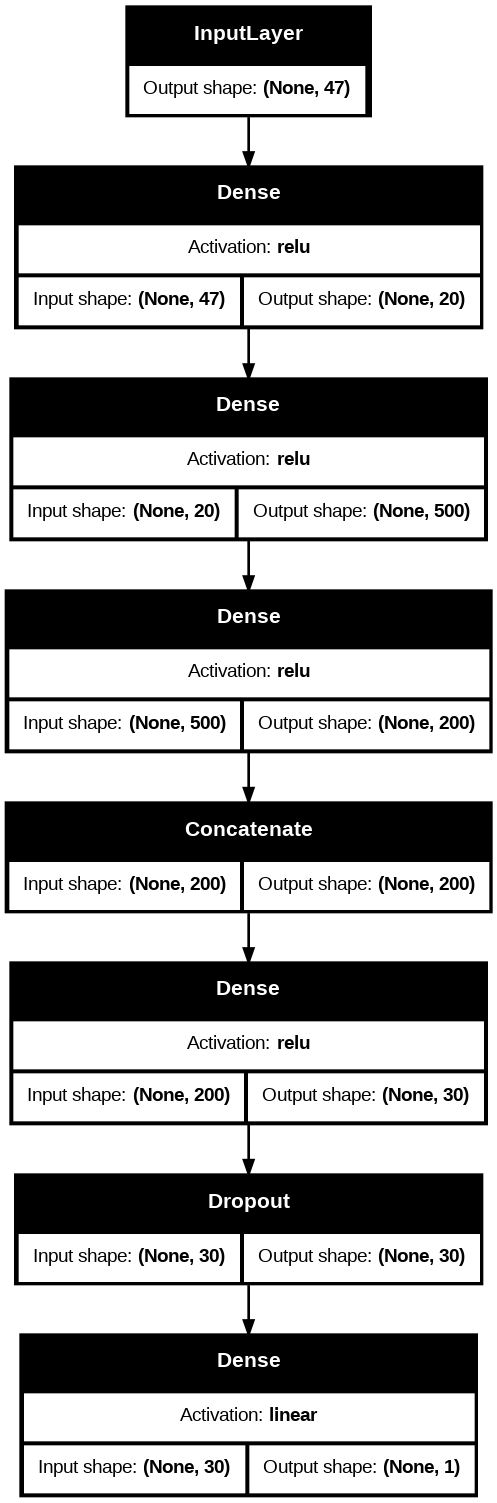

In [32]:
utils.plot_model(model, dpi=96, show_shapes=True, show_layer_activations=True)

In [37]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model.fit([x_train[:2200]],
                           y_train_scaled[:2200],
                           batch_size=256,
                           epochs=500,
                           validation_data=([x_train[2200:]], y_train_scaled[2200:]),
                           verbose=1)

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.8560 - mae: 0.7802 - val_loss: 2.2668 - val_mae: 1.4961
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8559 - mae: 0.7786 - val_loss: 2.2182 - val_mae: 1.4799
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8772 - mae: 0.7866 - val_loss: 2.1755 - val_mae: 1.4654
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8621 - mae: 0.7757 - val_loss: 2.1551 - val_mae: 1.4584
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8336 - mae: 0.7627 - val_loss: 2.1349 - val_mae: 1.4514
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8457 - mae: 0.7700 - val_loss: 2.1189 - val_mae: 1.4459
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8340 - mae: 0.7620 - val_loss: 2.1043 - val_mae: 1.4407
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8564 - mae: 0.7777 - val_loss: 2.0954 - val_mae: 1.4377
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8543 - mae: 

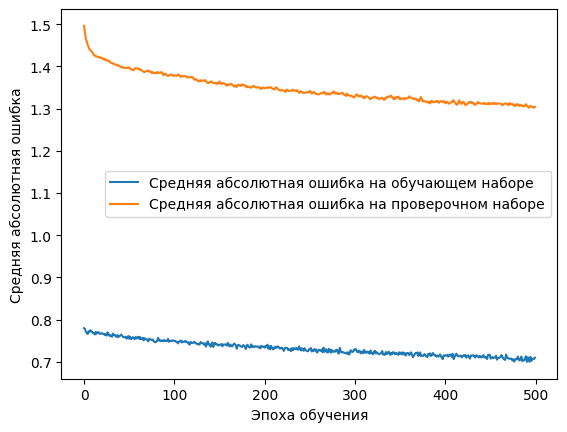

In [38]:
plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Средняя абсолютная ошибка: 3.8 

Реальное значение:  13.70  Предсказанное значение:   7.21  Разница:   6.49
Реальное значение:  13.70  Предсказанное значение:   7.38  Разница:   6.32
Реальное значение:  13.70  Предсказанное значение:   9.67  Разница:   4.03
Реальное значение:  13.70  Предсказанное значение:  10.59  Разница:   3.11
Реальное значение:  13.70  Предсказанное значение:  10.09  Разница:   3.61


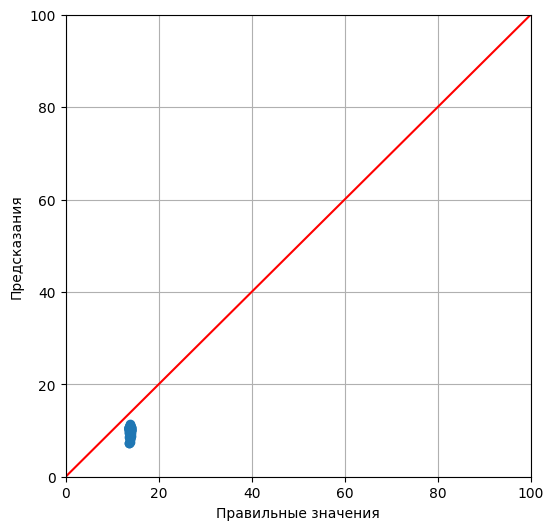

In [42]:
pred = model.predict([x_train[2200:2300]])  # Предсказание на новых данных (контрольный образец)

pred = y_scaler.inverse_transform(pred)    # Обратная нормированию процедура


print('Средняя абсолютная ошибка:', round(mean_absolute_error(pred, y_train[2200:2300]), 1), '\n') # расчет средней абсолютной ошибки

for i in range(5):
    print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[2200:2300][i, 0],
                                                                                                pred[i, 0],
                                                                                                abs(y_train[2200:2300][i, 0] - pred[i, 0])))
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_train[2200:2300], pred)          # Отрисовка точечного графика
ax.set_xlim(0, 100)                           # Ограничение оси по x
ax.set_ylim(0, 100)                           # Ограничение оси по x
ax.plot(plt.xlim(), plt.ylim(), 'r')          # Отрисовка диагональной линии
plt.xlabel('Правильные значения')
plt.ylabel('Предсказания')
plt.grid()
plt.show()